# FIOLA demo pipeline

Pipeline for online analysis of fluorescence imaging data

Voltage dataset courtesy of Karel Svoboda Lab (Janelia Research Campus).

Calcium dataset courtesy of Sue Ann Koay and David Tank (Princeton University)

@author: @agiovann, @caichangjia, @cxd00


In [2]:
from base64 import b64encode
import caiman as cm
from IPython.display import HTML, clear_output
import imageio
import logging
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pyximport
pyximport.install()
import scipy
from tensorflow.python.client import device_lib
from time import time
    
from fiola.demo_initialize_calcium import run_caiman_init
from fiola.fiolaparams import fiolaparams
from fiola.fiola import FIOLA
from fiola.utilities import download_demo, load, to_2D, movie_iterator, visualize

logging.basicConfig(format=
                    "%(relativeCreated)12d [%(filename)s:%(funcName)20s():%(lineno)s]"\
                    "[%(process)d] %(message)s",
                    level=logging.INFO)    
logging.info(device_lib.list_local_devices()) # if GPU is not detected, try to reinstall tensorflow with pip install tensorflow==2.4.1


       66632 [4055389737.py:            <module>():24][6093] [name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 4612173120071127997
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 23165076736
locality {
  bus_id: 1
  links {
  }
}
incarnation: 14545198211294418769
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:01:00.0, compute capability: 8.6"
]
2023-04-14 10:53:37.110152: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-04-14 10:53:37.110320: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-14 10:53:37.110818: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce RTX 3090 computeCapability: 8.6
coreClock: 1.695G

# Set up parameters

In [3]:
folder = '/home/nel/CODE/test_fiola/FIOLA'
mode = 'voltage'                    # 'voltage' or 'calcium 'fluorescence indicator
# Parameter setting
if mode == 'voltage':
    fnames = download_demo(folder, 'demo_voltage_imaging.hdf5')
    # setting params
    # dataset dependent parameters
    fr = 400                        # sample rate of the movie
    
    num_frames_init =  10000        # number of frames used for initialization
    num_frames_total =  20000       # estimated total number of frames for processing, this is used for generating matrix to store data
    offline_batch = 200             # number of frames for one batch to perform offline motion correction
    batch = 1                       # number of frames processing at the same time using gpu. 1 for online processing. 
    flip = True                     # whether to flip signal to find spikes   
    detrend = True                  # whether to remove the slow trend in the fluorescence data            
    do_deconvolve = True            # If True, perform spike detection for voltage imaging or deconvolution for calcium imaging.
    ms = [10, 10]                   # maximum shift in x and y axis respectively. Will not perform motion correction if None.
    update_bg = True                # update background components for spatial footprints
    filt_window = 15                # window size of median filter for removing the subthreshold activities. It can be integer or a list.
                                    # an integer means the window size of the full median filter. Suggested values range [9, 15]. It needs to be an odd number. 
                                    # a list with two values [x, y] means an antisymmetric median filter which uses x past frames and y future frames.
    minimal_thresh = 3.5            # minimal of the threshold for voltage spike detection. Suggested value range [2.8, 3.5] 
    template_window = 2             # half window size of the template; will not perform template matching if window size equals 0.  
    nb = 1                          # number of background components
    lag = 11                        # lag for retrieving the online result. 5 frames are suggested for calcium imaging. For voltage imaging, it needs to be larger than filt_window // 2 + template_window + 2. 

    options = {
        'fnames': fnames,
        'fr': fr,
        'mode': mode,
        'num_frames_init': num_frames_init, 
        'num_frames_total':num_frames_total,
        'offline_batch': offline_batch,
        'batch':batch,
        'flip': flip,
        'detrend': detrend,
        'do_deconvolve': do_deconvolve,
        'ms': ms,
        'update_bg': update_bg,
        'filt_window': filt_window,
        'minimal_thresh': minimal_thresh,
        'template_window':template_window, 
        'nb': nb, 
        'lag': lag}
    
    
    logging.info('Loading Movie')
    

elif mode == 'calcium':
    #fnames = download_demo(folder, 'demoMovie.tif') 
    fnames = download_demo(folder, 'Sue_2x_3000_40_-46.tif')
    fr = 30                         # sample rate of the movie
    
    mode = 'calcium'                # 'voltage' or 'calcium 'fluorescence indicator
    num_frames_init =   1000         # number of frames used for initialization
    num_frames_total =  2000        # estimated total number of frames for processing, this is used for generating matrix to store data
    offline_batch = 5               # number of frames for one batch to perform offline motion correction
    batch= 1                        # number of frames processing at the same time using gpu. 1 for online processing. 
    flip = False                    # whether to flip signal to find spikes   
    detrend = False                  # whether to remove the slow trend in the fluorescence data            
    dc_param = 0.9995               # DC blocker parameter for removing the slow trend in the fluorescence data. It is usually between
                                    # 0.99 and 1. Higher value will remove less trend. No detrending will perform if detrend=False.
    do_deconvolve = True            # If True, perform spike detection for voltage imaging or deconvolution for calcium imaging.
    ms = [5, 5]                     # maximum shift in x and y axis respectively. Will not perform motion correction if None.
    center_dims = None              # template dimensions for motion correction. If None, the input will the the shape of the FOV
    hals_movie = 'hp_thresh'        # apply hals on the movie high-pass filtered and thresholded with 0 (hp_thresh); movie only high-pass filtered (hp); 
                                    # original movie (orig); no HALS needed if the input is from CaImAn (when init_method is 'caiman' or 'weighted_masks')
    n_split = 1                     # split neuron spatial footprints into n_split portion before performing matrix multiplication, increase the number when spatial masks are larger than 2GB
    nb = 2                          # number of background components
    trace_with_neg=True             # return trace with negative components (noise) if True; otherwise the trace is cutoff at 0
    lag = 5                         # lag for retrieving the online result.
                    
    options = {
        'fnames': fnames,
        'fr': fr,
        'mode': mode, 
        'num_frames_init': num_frames_init, 
        'num_frames_total':num_frames_total,
        'offline_batch': offline_batch,
        'batch':batch,
        'flip': flip,
        'detrend': detrend,
        'dc_param': dc_param,            
        'do_deconvolve': do_deconvolve,
        'ms': ms,
        'hals_movie': hals_movie,
        'center_dims':center_dims, 
        'n_split': n_split,
        'nb' : nb, 
        'trace_with_neg':trace_with_neg, 
        'lag': lag}
else: 
    raise Exception('mode must be either calcium or voltage')

       66757 [utilities.py:       download_demo():62][6093] file demo_voltage_imaging.hdf5 already downloaded
       66759 [1493698638.py:            <module>():47][6093] Loading Movie


# Load movie.
### If dealing with calcium data, run initialization with CaImAn

In [4]:
if mode == 'voltage':
    logging.info('Loading Movie')
    mov = cm.load(fnames, subindices=range(num_frames_init))
    fnames_init = fnames.split('.')[0] + '_init.tif'
    mov.save(fnames_init)
    path_ROIs = download_demo(folder, 'demo_voltage_imaging_ROIs.hdf5')
    mask = load(path_ROIs)
    template = np.median(mov, 0)
    
elif mode == 'calcium':
    mov = cm.load(fnames, subindices=range(num_frames_init))
    fnames_init = fnames.split('.')[0] + '_init.tif'
    mov.save(fnames_init)
    
    # run caiman initialization. User might need to change the parameters 
    # inside the file to get good initialization result
    caiman_file = run_caiman_init(fnames_init, pw_rigid=True, 
                                      max_shifts=ms, gnb=nb, rf=15, K=4, gSig=[4, 4])
    
    # load results of initialization
    cnm2 = cm.source_extraction.cnmf.cnmf.load_CNMF(caiman_file)
    estimates = cnm2.estimates
    template = cnm2.estimates.template
    Cn = cnm2.estimates.Cn


       66878 [2729313155.py:            <module>():2][6093] Loading Movie
       75759 [utilities.py:       download_demo():62][6093] file demo_voltage_imaging_ROIs.hdf5 already downloaded


### Display calculated template and overlaid neuron masks from initialization.

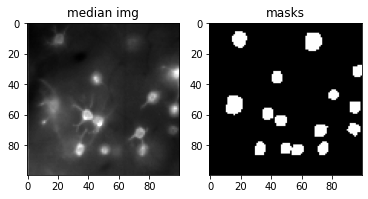

In [5]:
display_images = True
if display_images:
    fig, ax = plt.subplots(1, 2)
    ax[0].imshow(template, vmax=np.percentile(template, 99.9), cmap='gray')
    ax[0].set_title('median img')
    ax[1].set_title('masks')
    if mode == 'voltage':
        ax[1].imshow(mask.mean(0), cmap='gray')
    elif mode == 'calcium':
        Ab = np.hstack((estimates.A.toarray(), estimates.b))
        Ab = Ab.reshape([mov.shape[1], mov.shape[2], -1], order='F').transpose([2, 0, 1])
        ax[1].imshow(Ab.mean(0), cmap='gray')

In [6]:
template

movie([[2847. , 2470. , 2507. , ..., 2575. , 2601. , 2582. ],
       [2829. , 2453. , 2468. , ..., 2600. , 2590. , 2596. ],
       [2816. , 2446. , 2450. , ..., 2596. , 2586. , 2605. ],
       ...,
       [3916. , 3164. , 3159. , ..., 2776. , 2775. , 2768. ],
       [3916. , 3185. , 3212. , ..., 2808. , 2800. , 2789.5],
       [3936. , 3155. , 3191. , ..., 2833. , 2826. , 2810. ]],
      dtype=float32)

# GPU motion correction

In [7]:
#%% Run FIOLA: set variable to true to include that portion of the pipeline.
# example motion correction
motion_correct = True
# example source separation
do_nnls = True

In [8]:
#%% Mot corr only
if motion_correct:
    params = fiolaparams(params_dict=options)
    fio = FIOLA(params=params)
    # run motion correction on GPU on the initialization movie
    mc_nn_mov, shifts_fiola, _ = fio.fit_gpu_motion_correction(mov, template, fio.params.mc_nnls['offline_batch'], min_mov=mov.min())             
else:    
    mc_nn_mov = mov

       77586 [fiolaparams.py:                 set():108][6093] Changing key fnames in group data from None to /home/nel/CODE/test_fiola/FIOLA/demo_voltage_imaging.hdf5
       77587 [fiolaparams.py:                 set():108][6093] Changing key minimal_thresh in group spike from 3.0 to 3.5
       77588 [fiolaparams.py:                 set():108][6093] Changing key lag in group retrieve from 5 to 11
       77608 [fiola.py:fit_gpu_motion_correction():212][6093] Correct unction
2023-04-14 10:53:49.061835: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-04-14 10:53:49.062006: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-14 10:53:49.062492: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce RTX

2023-04-14 10:53:49.830658: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2023-04-14 10:53:50.188130: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.11
       79397 [fiola.py:           generator():203][6093] (1, 200, 100, 100, 1)
2023-04-14 10:53:50.196726: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcufft.so.10
2023-04-14 10:53:50.335054: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.8
2023-04-14 10:53:51.828485: I tensorflow/stream_executor/cuda/cuda_blas.cc:1838] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
       81091 [fiola.py:fit_gpu_motion_correction():232][6093] processed 1000 frames
       81162 [fiola.py:fit_gpu_motion_correction():232][6093] processed 2000 frames
       

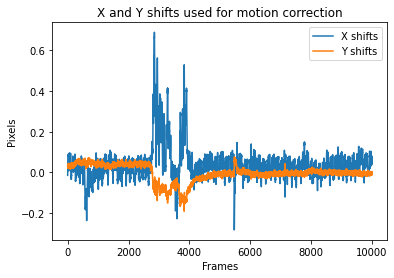

In [9]:
if motion_correct:
    plt.figure()
    plt.plot(shifts_fiola)
    plt.xlabel('Frames')
    plt.ylabel('Pixels')                 
    plt.legend(['X shifts', 'Y shifts'])
    plt.title('X and Y shifts used for motion correction')

In [10]:
if motion_correct:
    ds_ratio = 0.2
    moviehandle = cm.concatenate([mov.resize(1, 1, ds_ratio),
                                  cm.movie(mc_nn_mov).resize(1, 1, ds_ratio)], axis=2)
    moviehandle.play(fr=30, q_max=99.5, magnification=4)  # press q to exit

# GPU source extraction

In [11]:
#%% NNLS only
if do_nnls:
    params = fiolaparams(params_dict=options)
    fio = FIOLA(params=params)
    if mode == 'voltage':
        A = scipy.sparse.coo_matrix(to_2D(mask, order='F')).T
        fio.fit_hals(mc_nn_mov, A)
        Ab = fio.Ab # Ab includes spatial masks of all neurons and background
    else:
        Ab = np.hstack((estimates.A.toarray(), estimates.b))
    trace_fiola, _ = fio.fit_gpu_nnls(mc_nn_mov, Ab, batch_size=fio.params.mc_nnls['offline_batch']) 

else: 
    if mode == 'calcium':# use traces of CaImAn       
        if trace_with_neg == True:
            trace_fiola = np.vstack((estimates.C+estimates.YrA, estimates.f))
        else:
            trace_fiola = estimates.C+estimates.YrA
            trace_fiola[trace_fiola < 0] = 0
            trace_fiola = np.vstack((trace_fiola, estimates.f))

       86849 [fiolaparams.py:                 set():108][6093] Changing key fnames in group data from None to /home/nel/CODE/test_fiola/FIOLA/demo_voltage_imaging.hdf5
       86850 [fiolaparams.py:                 set():108][6093] Changing key minimal_thresh in group spike from 3.0 to 3.5
       86850 [fiolaparams.py:                 set():108][6093] Changing key lag in group retrieve from 5 to 11
       86851 [fiola.py:            fit_hals():116][6093] flipping movie for initialization
       86959 [utilities.py:       signal_filter():2339][6093] Filtering pixels up to:0
       91071 [fiola.py:            fit_hals():149][6093] regressing matrices
       91138 [fiola.py:            fit_hals():156][6093] computing hals
       91140 [utilities.py:                hals():1032][6093] Hals Iteration activity:1
       91408 [utilities.py:                hals():1060][6093] Hals Iteration shape:1
       91624 [utilities.py:                hals():1032][6093] Hals Iteration activity:2
       9187

2023-04-14 10:54:04.512347: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-04-14 10:54:04.512494: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-14 10:54:04.512659: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce RTX 3090 computeCapability: 8.6
coreClock: 1.695GHz coreCount: 82 deviceMemorySize: 23.69GiB deviceMemoryBandwidth: 871.81GiB/s
2023-04-14 10:54:04.512711: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2023-04-14 10:54:04.512732: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2023-04-14 10:54:04.512749: I tensorflow/stream_executor/platfor

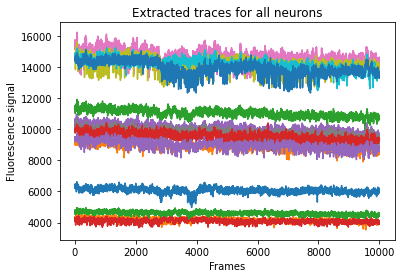

In [12]:
if do_nnls:
    plt.figure()
    plt.plot(trace_fiola[:-nb].T)
    plt.xlabel('Frames')
    plt.ylabel('Fluorescence signal') 
    plt.title('Extracted traces for all neurons')   

# Set up whole pipeline with initialization

In [13]:
#%% set up online pipeline
params = fiolaparams(params_dict=options)
fio = FIOLA(params=params)
if mode == 'voltage': # not thoroughly tested and computationally intensive for large files, it will estimate the baseline
    fio.fit_hals(mc_nn_mov, A)
    Ab = fio.Ab
else:
    Ab = np.hstack((estimates.A.toarray(), estimates.b))
Ab = Ab.astype(np.float32)        
fio = fio.create_pipeline(mc_nn_mov, trace_fiola, template, Ab, min_mov=mov.min())

       94239 [fiolaparams.py:                 set():108][6093] Changing key fnames in group data from None to /home/nel/CODE/test_fiola/FIOLA/demo_voltage_imaging.hdf5
       94239 [fiolaparams.py:                 set():108][6093] Changing key minimal_thresh in group spike from 3.0 to 3.5
       94240 [fiolaparams.py:                 set():108][6093] Changing key lag in group retrieve from 5 to 11
       94240 [fiola.py:            fit_hals():116][6093] flipping movie for initialization
       94351 [utilities.py:       signal_filter():2339][6093] Filtering pixels up to:0
       98574 [fiola.py:            fit_hals():149][6093] regressing matrices
       98643 [fiola.py:            fit_hals():156][6093] computing hals
       98645 [utilities.py:                hals():1032][6093] Hals Iteration activity:1
       98916 [utilities.py:                hals():1060][6093] Hals Iteration shape:1
       99141 [utilities.py:                hals():1032][6093] Hals Iteration activity:2
       9939

2023-04-14 10:54:12.424808: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-04-14 10:54:12.424964: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-14 10:54:12.425129: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce RTX 3090 computeCapability: 8.6
coreClock: 1.695GHz coreCount: 82 deviceMemorySize: 23.69GiB deviceMemoryBandwidth: 871.81GiB/s
2023-04-14 10:54:12.425183: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2023-04-14 10:54:12.425204: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2023-04-14 10:54:12.425222: I tensorflow/stream_executor/platfor

# Online analysis

In [14]:
time_per_step = np.zeros((num_frames_total-num_frames_init) // batch)
online_trace = np.zeros((fio.Ab.shape[-1], num_frames_total-num_frames_init), dtype=np.float32)
online_trace_deconvolved = np.zeros((fio.Ab.shape[-1] - fio.params.hals['nb'], num_frames_total-num_frames_init), dtype=np.float32)
start = time()
    
for idx, memmap_image in movie_iterator(fnames, num_frames_init, num_frames_total, batch_size=batch):
    if idx % 1000 == 0:
            print(f'processed {idx} frames')        
    fio.fit_online_frame(memmap_image) 
    online_trace[:, idx-num_frames_init:idx-num_frames_init+batch] = fio.pipeline.saoz.trace[:,idx-batch:idx]
    online_trace_deconvolved[:, idx-num_frames_init:idx-num_frames_init+batch] = fio.pipeline.saoz.trace_deconvolved[:,idx-batch-fio.params.retrieve['lag']:idx-fio.params.retrieve['lag']]
    time_per_step[(idx-num_frames_init)//batch] = (time()-start)

fio.pipeline.saoz.online_trace = online_trace
fio.pipeline.saoz.online_trace_deconvolved = online_trace_deconvolved
logging.info(f'total time online: {time()-start}')
logging.info(f'time per frame online: {(time()-start)/(num_frames_total-num_frames_init)}')


mapping CaImAn h5py/hdf5 file
processed 10000 frames


2023-04-14 10:54:12.806842: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-04-14 10:54:12.806998: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-14 10:54:12.807169: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce RTX 3090 computeCapability: 8.6
coreClock: 1.695GHz coreCount: 82 deviceMemorySize: 23.69GiB deviceMemoryBandwidth: 871.81GiB/s
2023-04-14 10:54:12.807233: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2023-04-14 10:54:12.807259: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2023-04-14 10:54:12.807280: I tensorflow/stream_executor/platfor

processed 11000 frames
processed 12000 frames
processed 13000 frames
processed 14000 frames
processed 15000 frames
processed 16000 frames
processed 17000 frames
processed 18000 frames
processed 19000 frames


      127127 [1615484359.py:            <module>():16][6093] total time online: 25.249817609786987
      127128 [1615484359.py:            <module>():17][6093] time per frame online: 0.0025250526905059812


Text(0.5, 1.0, 'Time per frame')

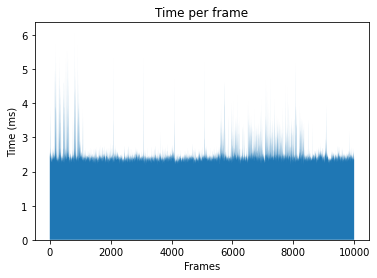

In [15]:
plt.figure()
plt.stackplot(range(len(np.diff(time_per_step))), np.diff(time_per_step)*1000)
plt.xlabel('Frames')
plt.ylabel('Time (ms)')
plt.title('Time per frame')

# Visualization

In [19]:
%matplotlib auto

Using matplotlib backend: TkAgg


In [20]:
fio.compute_estimates()
visualize(fio, img=template)

      148915 [fiola.py:   compute_estimates():101][6093] no queue or thread to delete
Traceback (most recent call last):
  File "/home/nel/anaconda3/envs/fiola-merge/lib/python3.8/site-packages/matplotlib/cbook/__init__.py", line 270, in process
    func(*args, **kwargs)
  File "/home/nel/anaconda3/envs/fiola-merge/lib/python3.8/site-packages/matplotlib/widgets.py", line 530, in <lambda>
    return self._observers.connect('changed', lambda val: func(val))
  File "/home/nel/CODE/VIOLA/fiola/utilities.py", line 1267, in update
    spatial = spatials[indexes][i].copy()
IndexError: index 15 is out of bounds for axis 0 with size 15


In [18]:
#%% save result
if True:
        np.save(folder + f'/fiola_result', fio.estimates)